In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk',
    palette='Set1'
)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



In [2]:
import warnings
warnings.filterwarnings('ignore')

[![scikit-learn logo](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)](http://scikit-learn.org/)

*Scikit-learn* is a Python package for **machine learning**:


- Simple and efficient tools for data mining and data analysis
- Accessible to everybody, and reusable in various contexts
- Built on NumPy, SciPy, and matplotlib
- Open source, commercially usable - BSD license

We will do [one of the many tutorials](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) from the *scikit-learn* website. 

You can install *scikit-learn* with `conda install scikit-learn`.

## Supervised learning: predicting an output variable from high-dimensional observations

Supervised learning consists in learning the link between two datasets: the observed data `X` and an external variable `y` that we are trying to predict, usually called “target” or “labels”. Most often, `y` is a 1D array of length `n_samples`.

All supervised estimators in *scikit-learn* implement a `fit(X, y)` method to fit the model and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.

## Possum dataset

The [Possum dataset](https://www.kaggle.com/datasets/abrambeyer/openintro-possum) comprises nine morphometric measurements for each of the 104 mountain brushtail possums captured at seven locations spanning from Southern Victoria to central Queensland.  

<img src="https://storage.googleapis.com/kaggle-datasets-images/1534513/2532158/c49c3c89019ed2251376ecfcf7a7eec0/dataset-cover.jpg?t=2021-08-17-01-33-40" width="200"/>

Let's start by loading the dataset.

In [3]:
filename = '../data/possum.csv'
possum_data = pd.read_csv(filename)
possum_data.head()


,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


## Goal

*We aim to build a model that predicts the **belly size* ('belly') based on the rest of features within the dataset*
.

# Basic data preprocessing and visualization

Data visualization is an important step before applying machine-learning models.



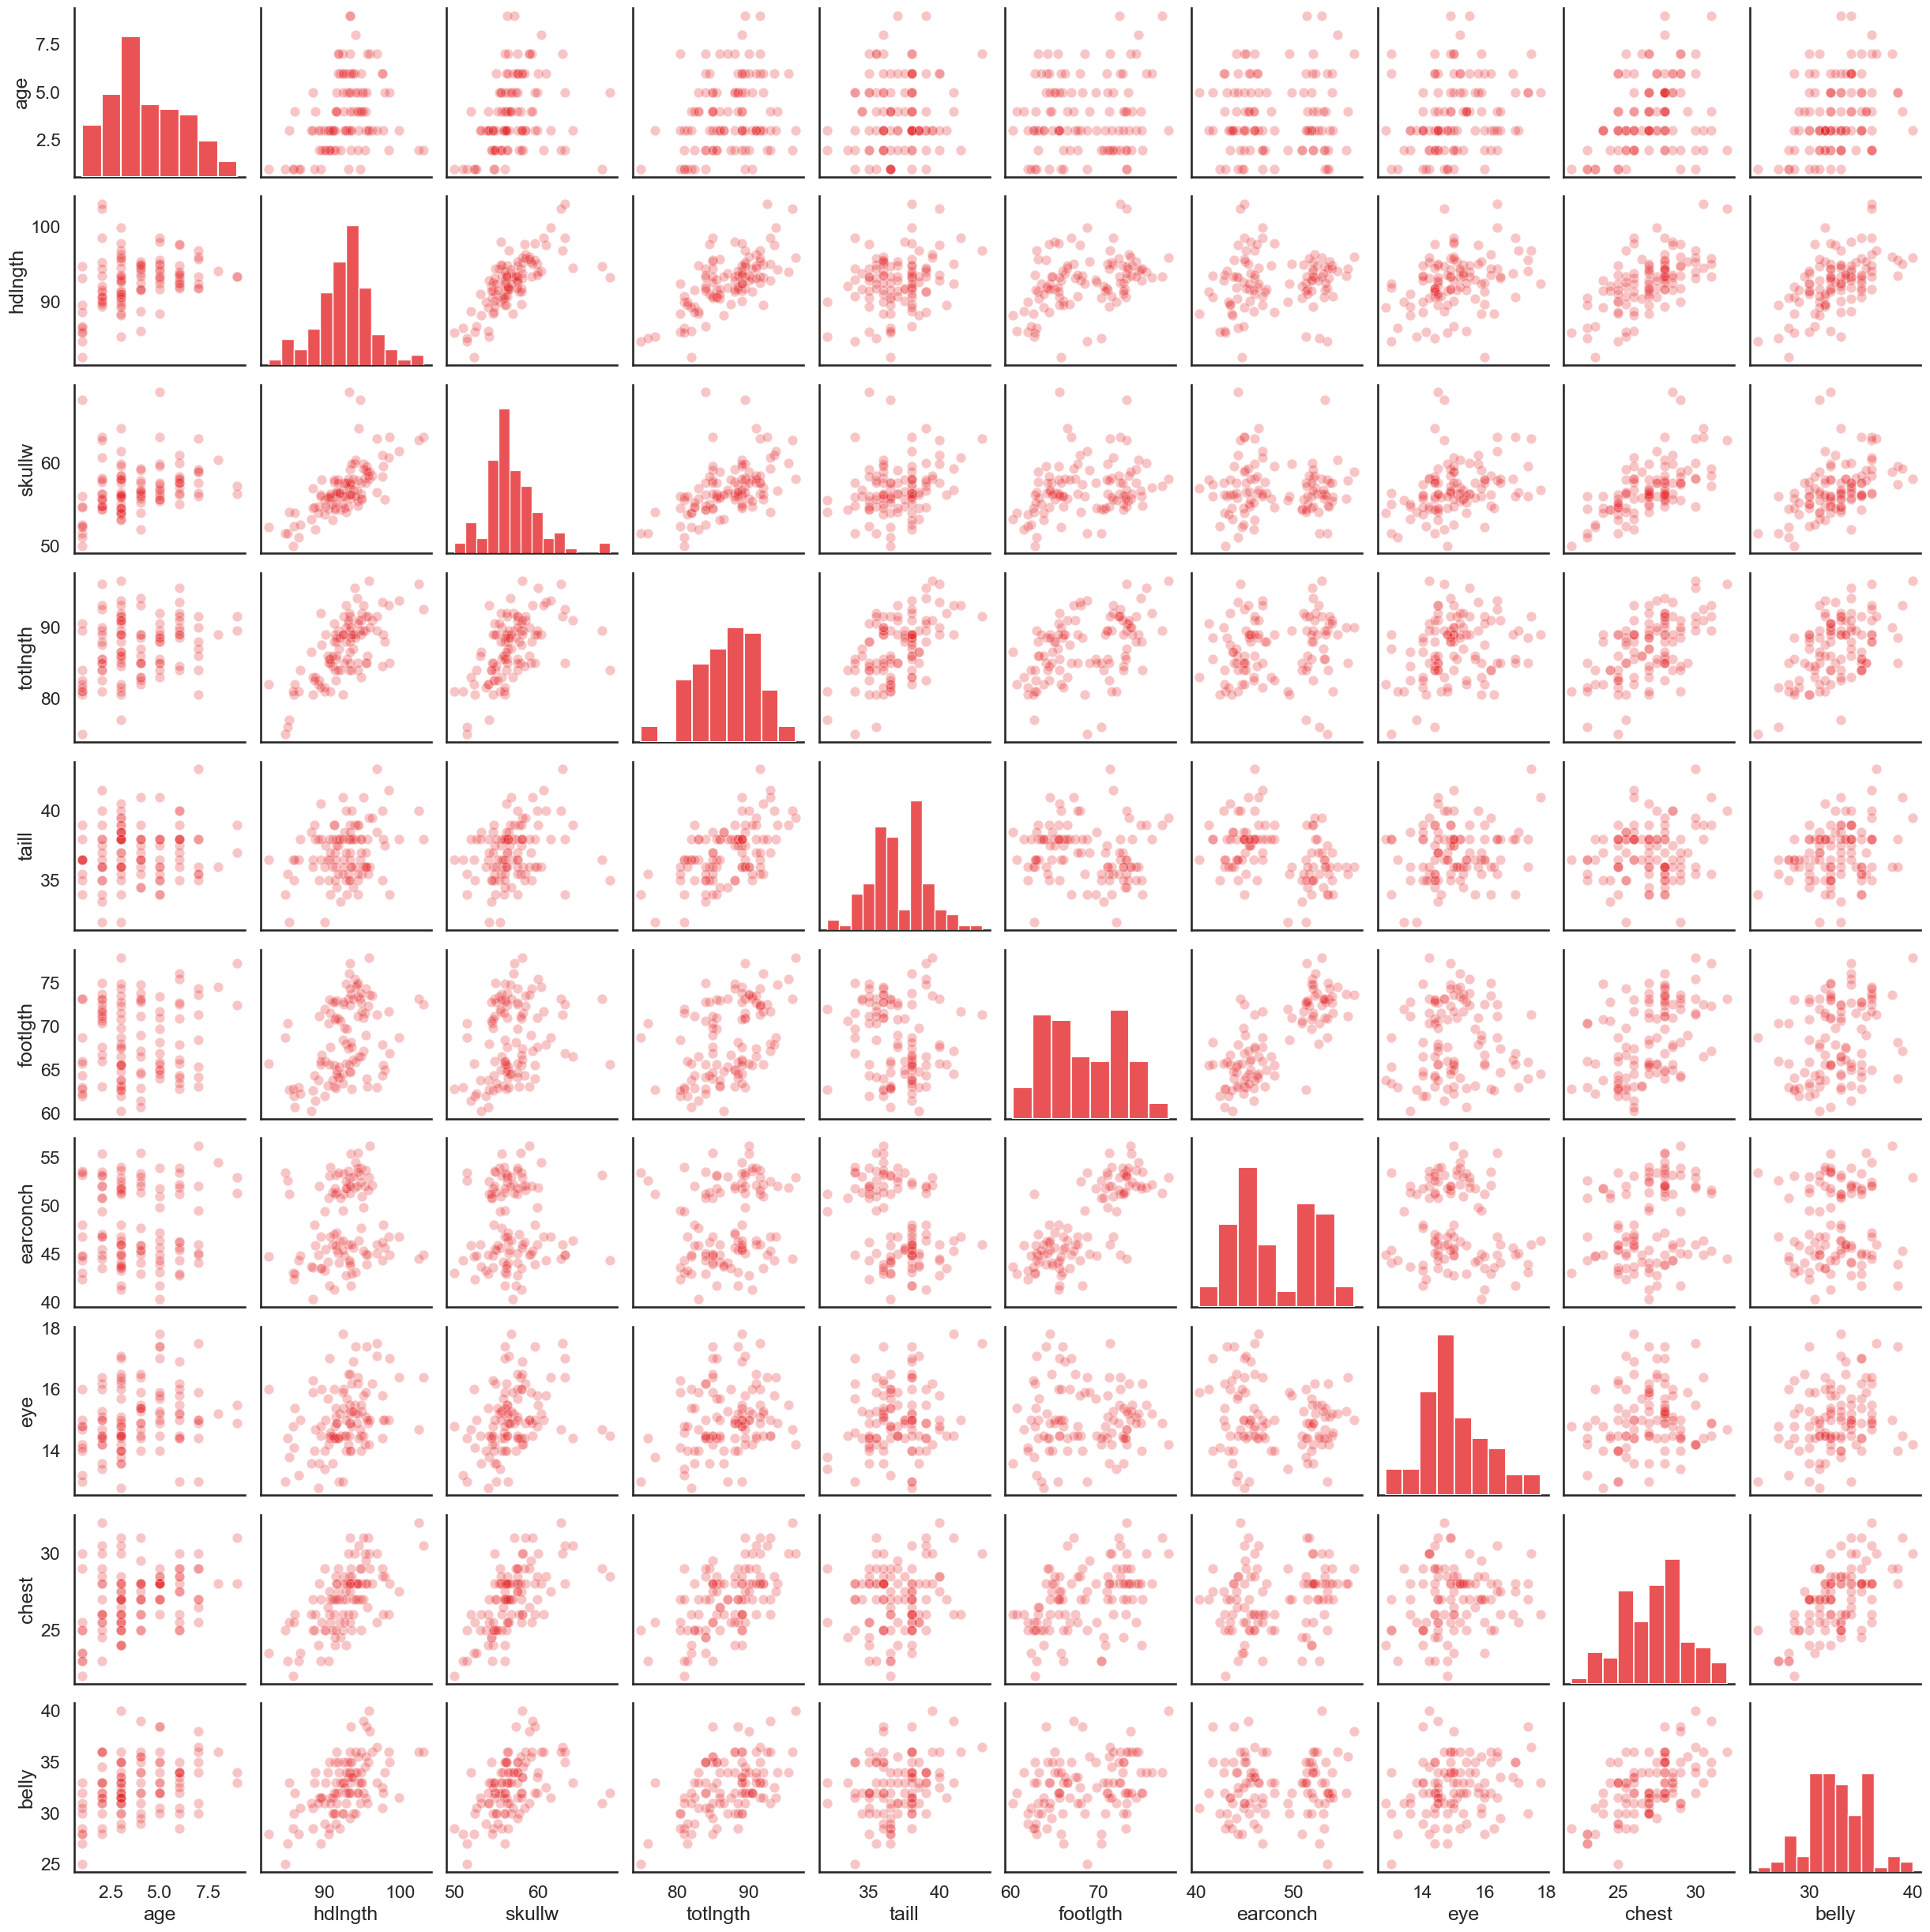

In [4]:
sns.pairplot(possum_data.drop(columns=['site','sex','case','Pop']), plot_kws=dict(alpha=0.25));
#pd.plotting.scatter_matrix(possum_data[['hdlngth','totlngth','taill','skullw']], alpha=0.2);


Now let's check for missing values in the dataset.

In [5]:
possum_data.isnull().sum()


case        0
site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

### Handling missing data
We observe missing values in the age and footlength columns. Different approaches can be taken to address this issue, including [imputation for missing values](https://scikit-learn.org/stable/modules/impute.html). However, due to the small number of rows affected, we will simply remove these rows
.

In [6]:
possum_data = possum_data.dropna(axis=0)


### Handling categorical features
We have several categorical columns in our dataset: 'sex','site' (the site number in which the possum was trapped),'Pop' (population). In order to include them in a machine-learning model, we need to transform them to numerical values. There are several approaches for this. Here, we will use **one hot encoding**.





<img src="https://datagy.io/wp-content/uploads/2022/01/One-Hot-Encoding-for-Scikit-Learn-in-Python-Explained-1024x576.png" width="400"/>



Let's see the different values obtained for each categorical varialbe:

In [7]:
print(f"Population values: {possum_data['Pop'].unique()}")
print(f"Sex values: {possum_data['sex'].unique()}")
print(f"Site values: {possum_data['site'].unique()}")

Population values: ['Vic' 'other']
Sex values: ['m' 'f']
Site values: [1 2 3 4 5 6 7]


#### Exercise 0:

Plot the number of observations from each site.

In [8]:
#Your code here

Let's apply the one hot encoding on the 'sex' ,'Pop' and 'site' columns:

In [9]:
possum_data_ = pd.get_dummies(possum_data ,prefix=['sex','Pop','site'], columns = ['sex','Pop','site'], drop_first=True)
possum_data_.head()


,case,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,sex_m,Pop_other,site_2,site_3,site_4,site_5,site_6,site_7
0,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,True,False,False,False,False,False,False,False
1,2,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,False,False,False,False,False,False,False,False
2,3,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,False,False,False,False,False,False,False,False
3,4,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,False,False,False,False,False,False,False,False
4,5,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,False,False,False,False,False,False,False,False


### Training set and testing set

While experimenting with any learning algorithm, it is important not to test the prediction of an estimator on the data used to fit the estimator as this would not be evaluating the performance of the estimator on new data. This is why datasets are often split into train and test data.

Split the dataset to train and test data using a random permutation - this is easily done with functions from the model_selection module, which has many methods to split datasets. We'll use a very simple one, train_test_split which just splits that data by sampling a fraction of the rows to the training set and the rest to the test set (without replacement).

Now let's split our data to train and test, using the `train_test_split` function.

In [10]:

#possum_data_ = possum_data_.sample(frac=1,random_state=0) #ignore this row and do not change

X = possum_data_.drop(columns = ['case','belly']) #remove our target variable , the row index and the site variable
y = possum_data_['belly']
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size =0.2, random_state = 0)


Let's start with a linear regression model.

In [11]:
lm = LinearRegression()
lm.fit(x_train,y_train)
lm_train_score = lm.score(x_train,y_train)
lm_test_score = lm.score(x_test,y_test)
print(f"Linear model train score = {round(lm_train_score,2)}, Linear model test score = {round(lm_test_score,2)}")



Linear model train score = 0.5, Linear model test score = -0.04


In [12]:
lm.coef_

array([-0.01531074,  0.08377758,  0.39641671, -0.07669995,  0.29378657,
        0.07746157,  0.074907  , -0.11495383,  0.47754757, -0.42294023,
       -0.02004703, -0.60012349,  1.17782546, -2.21536219,  0.22995391,
        0.95080804, -0.16327224])

The test score is close to zero, suggesting the model hasn't learned anything useful. In contrast, the training score is significantly higher at 0.5, indicating a clear case of **overfitting**. What strategies can we employ to address this issue?

## Regularized linear models:
The training score is much higher than the test score.
We clearly have overfitting here. One way to deal with overfitting is to use **regularization**.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Regularization.svg/500px-Regularization.svg.png" width="300"/>


In a standard linear regression model, we aim to minimize the residuals-sum-of-squares (RSS) loss funcion:

$\sum_{i=1}^{n}(y-y_{h})^2$ , where $y_{h}$ the model's prediction.

To avoid overfitting, in regularized linear models we add a **penalty term** to the loss function. The penalty term 
is controled by a parameter called $\lambda$. Larger values of $\lambda$ generally result in stronger regularization.


##### Lasso regression (L1 regularization): 

Leads to *sparse* models, by adding a penalty based on the absolute values of the coefficients. The model **zeros** coefficients of features which are less useful. 

In the [Lasso model](https://en.wikipedia.org/wiki/Lasso_(statistics)) the loss function is given by:
$\sum_{i=1}^{n}(y-y_{h})^2+\lambda\sum_{i=1}^{q}\theta_{i}$

The Lasso model 


##### Ridge regression (L2 regularization): 

Shrinkgs coefficients toward zero, and thus encourages small, equally distributed coefficients based on a penalty on the square of the coefficients.

In the [Ridge model](https://en.wikipedia.org/wiki/Ridge_regression) model,  the loss function is given by: $\sum_{i=1}^{n}(y-y_{h})^2+\lambda\sum_{i=1}^{q}\theta_{i}^2$





### Data standartization


<img src="https://miro.medium.com/v2/resize:fit:992/1*dZlwWGNhFco5bmpfwYyLCQ.png" width="400"/>


Before employing Lasso or Ridge regression, it's essential to make sure the features have the same scale using a preprocessing step called standartization. **This ensures that the magnitude of coefficients, which is penalized in this algorithms, reflects their relative importance accurately and does not depend on the feature's scale**. 

Data standardization is commonly achieved by centering around the mean and dividing by the standard deviation, following the formula:

$z= (x-\mu)/\sigma$

(Note that there are other scaling techniques, see [common scaling approaches](https://scikit-learn.org/stable/modules/preprocessing.html))

* To prevent data leakage, feature standardization should occur **after splitting the data**, and exclusively on the training set. The mean and standard deviation should be computed **solely using the training data** and subsequently applied to the test data.

* What about linear regression? is standartization needed?
Standardization doesn't alter the performance of standard linear regression . It only impacts the coefficients derived from the regression. After standardization, these coefficients become unit-less, and represent the relative importance of each feature to the model's predictions. 

Let's standarize the training-set and the test set accordingly.

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test) # using the same mean and variance to scale the corresponding test features

________________
Let's apply **Lasso** regression with the default parameters using the `Lasso` module within the scikit-learn linear model library. Note that in this library the $\lambda$ parameter is termed 'alpha'.

In [14]:
lm_lasso = Lasso()
lm_lasso.fit(x_train_st,y_train)
lm_lasso_train_score = lm_lasso.score(x_train_st,y_train)
lm_lasso_test_score = lm_lasso.score(x_test_st,y_test)
print(f"Lasso train score = {round(lm_lasso_train_score,2)}, Lasso test score = {round(lm_lasso_test_score,2)}")


Lasso train score = 0.23, Lasso test score = 0.27


The Lasso model did better on the new data but not as well on the training data, showing how it helps prevent overfitting. This means the Lasso model is good at making predictions on fresh data it hasn't seen before, thanks to its regularization process.
Note that the Lasso model tends to zero some of the coefficients (a consequence of this specific type of regularization):

In [15]:
print(f'Lasso coefficients: {lm_lasso.coef_}')

Lasso coefficients: [ 0.          0.          0.27272787  0.          0.          0.
  0.          0.          0.38820323 -0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.        ]


Note that most of the coefficients are exactly zero.

Let's fit the `ridge` model as well:

In [16]:
lm_ridge = Ridge()
lm_ridge.fit(x_train_st,y_train)
lm_ridge_train_score = lm_ridge .score(x_train_st,y_train)
lm_ridge_test_score = lm_ridge .score(x_test_st,y_test)
print(f"Ridge train score = {round(lm_ridge_train_score,2)}, Ridge test score = {round(lm_ridge_test_score,2)}")


Ridge train score = 0.5, Ridge test score = 0.03


In [17]:
print(f'Ridge coefficients: {lm_ridge.coef_}')

Ridge coefficients: [-0.01011815  0.29783843  0.9220743  -0.2452362   0.56999543  0.33148611
  0.2532677  -0.11478383  0.82433447 -0.19371814  0.03562657 -0.1697878
  0.28006536 -0.48775949  0.01730211  0.24764202 -0.10055206]


The ridge test score is very low. So far, we fitted the Lasso and Ridge models using the default $\lambda = 1$  (termed *alpha* in the documentation).
It is not necessarily optimal. Maybe we can improve the perofrmance by adjusting the *alpha* vlaues?

### Ex1


Apply the Ridge regression model to the training set using each alpha from the specified grid [1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100,1000]. Subsequently, visualize the performance of the various models on the test set in terms of their R-squared scores against alpha values.

In [18]:
#Your code here

Based on the plot, it appears that alpha = 100 yields optimal performance on the test set. However,  selecting based on the performance on the test set can lead to overfitting! (but, on the test-data this time). It's crucial to remember that the **test set should remain untouched** during the model selection process to prevent biased evaluations. Instead, techniques like cross-validation can help in selecting the best hyperparameters without introducing bias from the test set. 
## Using cross validation to improve model's performance:

The default hyperparameters are not always optimal. How can we tune them?
To tune them, we can use a very common approach called **cross validation**.
We divide the training set into *n* folds. During each iteration, the model is trained on *n*-1 folds and evaluated on the remaining fold. The average score calculated over these iterations provides us with an estimation of the model's predictive performance on new, unseen data. This process, known as cross-validation, allows for a robust assessment of the model's generalization capabilities.


<img src="https://www.sharpsightlabs.com/wp-content/uploads/2024/02/5-fold-cross-validation_SIMPLE-EXAMPLE_v2.png" width="500"/>

For example, let's obtain the cross validation score for the Ridge model (using the default alpha) using 5 folds. First, we will use the [Kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function to split the data to 5 folds:

In [19]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

In [20]:
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")


Fold 0:
  Train: index=[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100]
  Test:  index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100]
  Test:  index=[34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47

In [21]:
ridge = Ridge()
x_train_arr = x_train_st
y_train_arr = y_train.values
fold_scores = []
for train_index, val_index in kf.split(x_train_arr):
    X_train_fold, X_val_fold = x_train_arr[train_index], x_train_arr[val_index]
    y_train_fold, y_val_fold = y_train_arr[train_index], y_train_arr[val_index]
    
    # Fit the model on the training fold
    ridge.fit(X_train_fold, y_train_fold)
    
    # Calculate R-squared score for the validation fold
    r2_fold = ridge.score(X_val_fold, y_val_fold)
    fold_scores.append(r2_fold)
print(f"CV scores on each fold: {fold_scores}")
print(f'Mean CV score = {round(np.mean(fold_scores),2)}')

CV scores on each fold: [-0.1434667721221805, 0.1396483116677758, 0.12336984651961747]
Mean CV score = 0.04


We can use the `cross_val_score` function instead to obtain the same result:

In [22]:
cv_scores = cross_val_score(Ridge(), x_train_st, y_train, cv = 3)
print(f"CV scores on each fold: {cv_scores}")
print(f'Mean CV score = {round(np.mean(cv_scores),2)}')

CV scores on each fold: [-0.14346677  0.13964831  0.12336985]
Mean CV score = 0.04


How can we select an optimal value of alpha using cross validation?
To pick the best alpha value, we try out lots of different values. For each value, we use cross validation split our training data into chunks and see how well the model does on average across these chunks. Then, we choose the alpha that gives us the best average score. 
For . We can use the function `GridSearchCV` in order to obtain the best hyperparameters using cross validation:

In [23]:
from sklearn.linear_model import Ridge

RidgeRegression = Ridge()
hyperParameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,200,400,600]}
ridgeRegressor = GridSearchCV(RidgeRegression, hyperParameters, cv=3)
ridgeRegressor.fit(x_train_st,y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100, 200, 400,
                                   600]})

In [24]:
print("Best value for lambda : ",ridgeRegressor.best_params_)
print("Best score for cost function: ", ridgeRegressor.best_score_) #mean CV score

Best value for lambda :  {'alpha': 100}
Best score for cost function:  0.2536252514647869


Now let's estimate the performance on the test set:

In [25]:
ridgeRegressor.score(x_test_st, y_test)

0.38625865540127646

The chosen alpha greatly improves the performance compared to the default alpha for the Ridge model! 
This demonstrates why tweaking hyperparameters is crucial.
### Ex2
Use `GridSearchCV` to tune the optimal alpha for the Lasso model. Did we improve the performance this time?

In [26]:
#Your code here

### Feature selection using cross validation

Feature selection is the process of choosing the most relevant and important features from a set of variables in a dataset. It aims to improve the performance of a model by focusing on the most informative aspects while discarding less useful or redundant features. This helps in simplifying the model, reducing overfitting, and enhancing its interpretability. Effective feature selection can lead to more efficient and accurate machine learning models, especially when dealing with high-dimensional datasets.


Let's start by creating all combinations of 15 out of 16 features:

In [27]:
from itertools import combinations
feature_names = x_train.columns
column_combs = combinations(feature_names , len(feature_names)-1)
column_combs = list(column_combs)
column_combs[0]

('age',
 'hdlngth',
 'skullw',
 'totlngth',
 'taill',
 'footlgth',
 'earconch',
 'eye',
 'chest',
 'sex_m',
 'Pop_other',
 'site_2',
 'site_3',
 'site_4',
 'site_5',
 'site_6')

Now, let's try all possible combinations of 15 out of 16 features in the linear regression model:

In [28]:
scores = np.empty(len(feature_names))
for j,comb in enumerate(column_combs):
    reg = LinearRegression()
    reg.fit(x_train[list(comb)], y_train)
    scores[j] = reg.score(x_test[list(comb)], y_test)

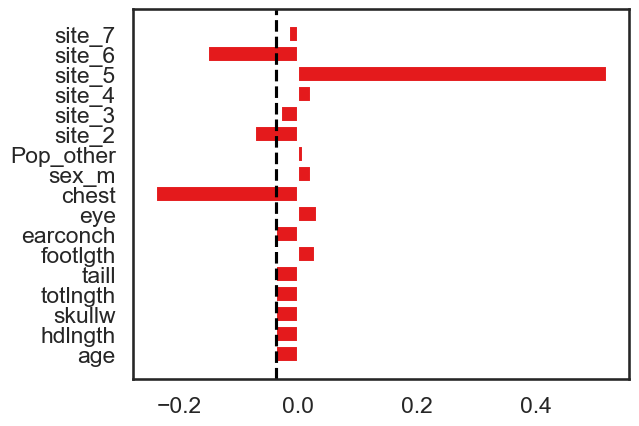

In [29]:
plt.barh(feature_names, scores)
plt.axvline(lm_test_score, ls='--', color='k');

Removing chest,site_2,site_6 individually, leads to an improvement in the test set score. 
However, should we use the test set in order to perform feature selection? No! this would result in *overfitting on the test set*. **We should not use the test-set for fine-tuning the model, but only for the last model evaluation!**

It's important to consider whether this improvement is merely a result of chance due to the train-test split. To address this potential randomness and obtain a more reliable evaluation, we conduct multiple splits and average the scores using **cross-validation**.

In [30]:
all_features_cv_scores = cross_val_score(LinearRegression(), x_train, y_train, cv=3)

feature_selection_scores = np.array([
    cross_val_score(LinearRegression(), x_train[list(comb)], y_train, cv=3)
    for comb in column_combs
])
feature_selection_scores

array([[-0.18423484,  0.0757453 ,  0.06653123],
       [-0.18423484,  0.0757453 ,  0.06653123],
       [-0.18423484,  0.0757453 ,  0.06653123],
       [-0.18423484,  0.0757453 ,  0.06653123],
       [-0.18423484,  0.0757453 ,  0.06653123],
       [-0.16978649,  0.12990905,  0.08767449],
       [-0.18423484,  0.0757453 ,  0.06653123],
       [-0.16713642,  0.09885774,  0.06758068],
       [-0.31564759,  0.07549042, -0.0211185 ],
       [-0.18552292,  0.10093989,  0.06450286],
       [-0.19412789,  0.11883406,  0.21439376],
       [-0.05340462,  0.07317409,  0.06255347],
       [-0.18458246,  0.12098893,  0.06070467],
       [-0.1913948 ,  0.16510654,  0.06761038],
       [-0.29588474,  0.04409065,  0.00078558],
       [-0.16754934,  0.08121618,  0.06619399],
       [-0.15269682,  0.07082086,  0.06661553]])

This provided us with cross-validation scores for each combination of features across all five iterations of the cross-validation process. Let's calculate the mean CV score for each combination:

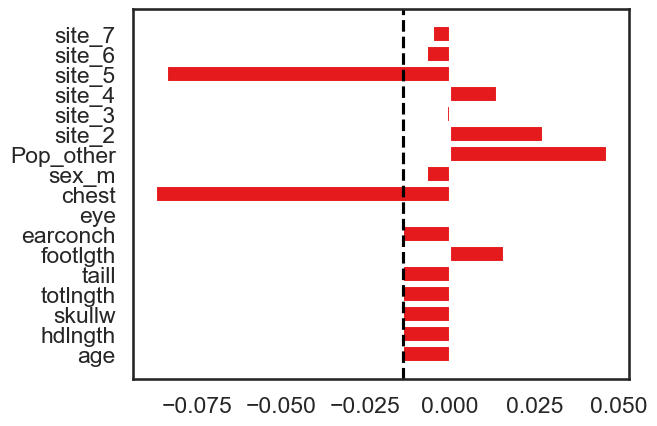

In [31]:
mean_cv_score_all_features = np.mean(all_features_cv_scores)
mean_cv_score_per_comb = np.mean(feature_selection_scores, axis = 1)
plt.barh(feature_names, mean_cv_score_per_comb)
plt.axvline(mean_cv_score_all_features, ls='--', color='k');


_______________________________________________________

Here, we only tested one simple approach to feature selection. There are [different approaches](https://scikit-learn.org/stable/modules/feature_selection.html) to perform feature selection which are implemented in the Scikit-learn package. One common approach is **recursive feature elimination (RFE)**.

Recursive Feature Elimination (RFE) is like a step-by-step process where a model learns and adapts by repeatedly removing the least important features until it finds the best combination.

1. Start with all features and train your machine learning model using the entire set of features.
2. Evaluate the model's performance using cross-validation.
3. Rank the features based on their importance or contribution to the model's performance. 
4. Remove the least important feature from the dataset.

*Repeat steps 2 to 4 with the reduced set of features. Train the model, evaluate performance, rank features, and eliminate the least important one.Continue this process until a model's performance start decreasing. The number of features at this point is considered optimal. Continue this process until a predefined number of features or a certain performance threshold is reached. The number of features at this point is considered optimal.*

5. Train your final model using the selected optimal features on the entire dataset.

We will use the `RFECV` implementation in the Scikit-learn package for the linear regression model!

In [32]:
from sklearn.feature_selection import RFECV
lm = LinearRegression()
rfecv = RFECV(
    estimator=lm,
    step=1,
    cv=5,
)
rfecv.fit(x_train, y_train)

RFECV(cv=5, estimator=LinearRegression())

In [33]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 8


Let's plot the mean accuracy across cross validation folds as a function of number of features added to the model:

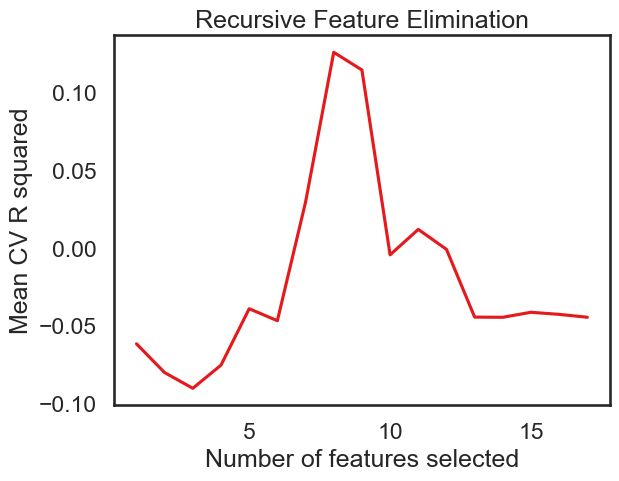

In [34]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean CV R squared")
plt.plot(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"]
)
plt.title("Recursive Feature Elimination")
plt.show()